
🔎 Checking model: Anesthetic Amount
  ➤ Number of importances: 10
  ➤ Non-zero importance features (10):
                      Feature  Importance
3    Wound Management (H/M/L)    0.287337
0           Lesion  Size (cm)    0.190349
8         Bleeding Risk (Y/N)    0.158471
2  Aggressive Histology (Y/N)    0.126835
7      Immunosuppressed (Y/N)    0.116744
1       Recurrent Tumor (Y/N)    0.066408
6                 Age (years)    0.023718
4            Location (H/M/L)    0.017763
5      Treatment Delay (days)    0.008140
9  Greater Average Time (Y/N)    0.004235


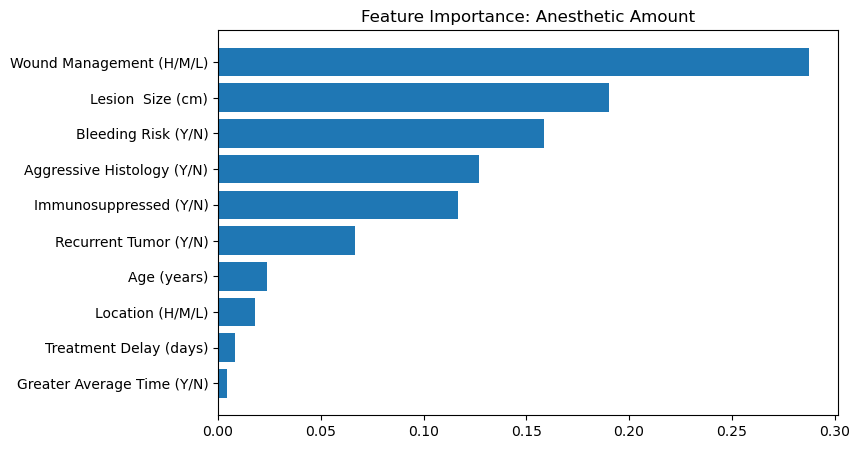


🔎 Checking model: Normalized Complexity Score
  ➤ Number of importances: 10
  ➤ Non-zero importance features (10):
                      Feature  Importance
0           Lesion  Size (cm)    0.196040
1       Recurrent Tumor (Y/N)    0.165045
2  Aggressive Histology (Y/N)    0.163725
3    Wound Management (H/M/L)    0.130280
7      Immunosuppressed (Y/N)    0.123060
8         Bleeding Risk (Y/N)    0.078165
4            Location (H/M/L)    0.066898
9  Greater Average Time (Y/N)    0.028503
6                 Age (years)    0.027528
5      Treatment Delay (days)    0.020756


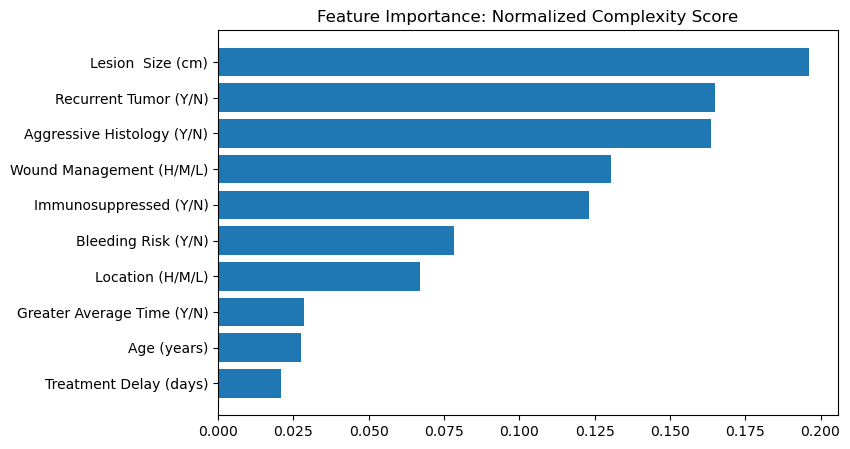


🔎 Checking model: Number of Stages (continuous)
  ➤ Number of importances: 10
  ➤ Non-zero importance features (10):
                      Feature  Importance
1       Recurrent Tumor (Y/N)    0.347879
2  Aggressive Histology (Y/N)    0.170697
4            Location (H/M/L)    0.153255
7      Immunosuppressed (Y/N)    0.131014
0           Lesion  Size (cm)    0.058583
9  Greater Average Time (Y/N)    0.030478
8         Bleeding Risk (Y/N)    0.029492
6                 Age (years)    0.027016
5      Treatment Delay (days)    0.026527
3    Wound Management (H/M/L)    0.025059


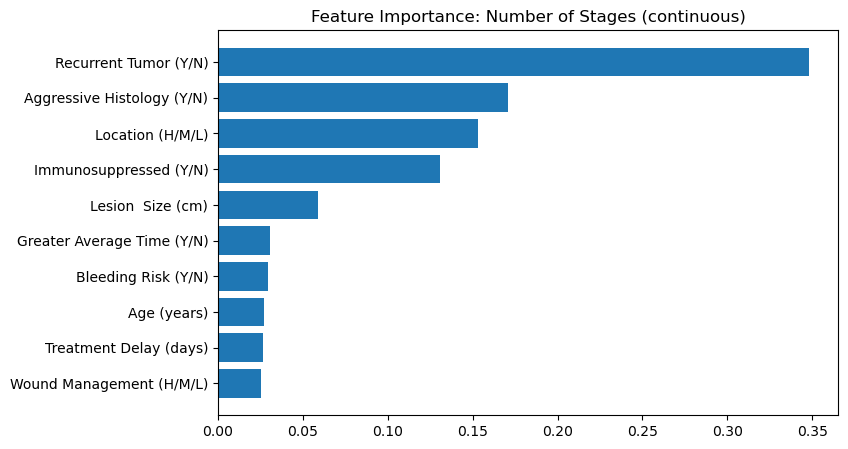


🔎 Checking model: Visit Duration
  ➤ Number of importances: 10
  ➤ Non-zero importance features (10):
                      Feature  Importance
0           Lesion  Size (cm)    0.276513
3    Wound Management (H/M/L)    0.243502
2  Aggressive Histology (Y/N)    0.113238
8         Bleeding Risk (Y/N)    0.090083
1       Recurrent Tumor (Y/N)    0.082605
9  Greater Average Time (Y/N)    0.067194
7      Immunosuppressed (Y/N)    0.066392
4            Location (H/M/L)    0.033138
6                 Age (years)    0.016679
5      Treatment Delay (days)    0.010657


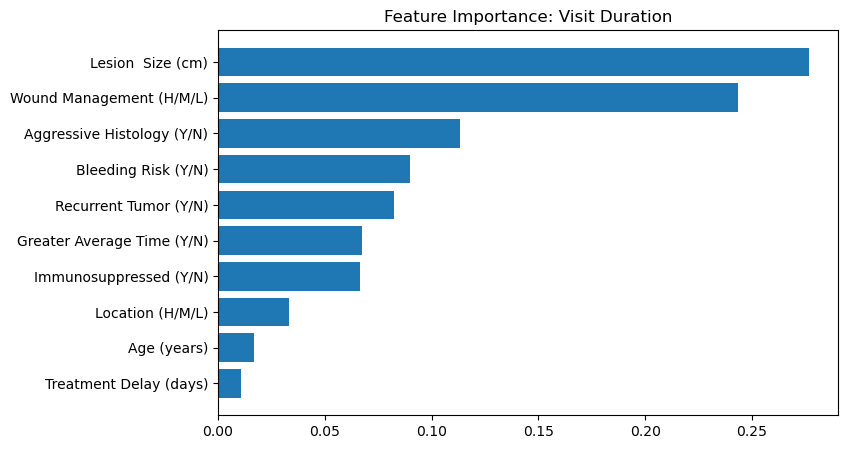

In [3]:
import joblib
import pandas as pd
import os
import matplotlib.pyplot as plt

# ==========================
# Define paths and metadata
# ==========================

base_dir = "models"

regressor_model_paths = {
    "Anesthetic Amount": os.path.join(base_dir, "xgb_regressor_anesthetic_amount.pkl"),
    "Normalized Complexity Score": os.path.join(base_dir, "xgb_regressor_normalized_visit_complexity_kmeans.pkl"),
    "Number of Stages (continuous)": os.path.join(base_dir, "xgb_regressor_number_of_stages.pkl"),
    "Visit Duration": os.path.join(base_dir, "xgb_regressor_visit_duration.pkl")
}

# The raw feature names you used at training (not one-hot encoded!)
regressor_features = [
    'Lesion  Size (cm)',
    'Recurrent Tumor (Y/N)',
    'Aggressive Histology (Y/N)',
    'Wound Management (H/M/L)',
    'Location (H/M/L)',
    'Treatment Delay (days)',
    'Age (years)',
    'Immunosuppressed (Y/N)',
    'Bleeding Risk (Y/N)',
    'Greater Average Time (Y/N)'
]

reduced_features = [f for f in regressor_features if f != 'Greater Average Time (Y/N)']

# ==========================
# Loop over models
# ==========================

for name, path in regressor_model_paths.items():
    print(f"\n🔎 Checking model: {name}")
    
    model = joblib.load(path)
    importances = model.feature_importances_
    n_importances = len(importances)
    
    print(f"  ➤ Number of importances: {n_importances}")
    
    # Match feature names based on length:
    if n_importances == len(regressor_features):
        feature_list = regressor_features
    elif n_importances == len(reduced_features):
        feature_list = reduced_features
    else:
        feature_list = [f"Feature_{i}" for i in range(n_importances)]
        print("  ⚠️ Warning: Feature count mismatch — using generic names.")

    # Create importance dataframe:
    importance_df = pd.DataFrame({
        'Feature': feature_list,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Print features with non-zero importance:
    important_features = importance_df[importance_df['Importance'] > 0]
    print(f"  ➤ Non-zero importance features ({len(important_features)}):")
    print(important_features)

    # Optional: plot
    plt.figure(figsize=(8, 5))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.title(f"Feature Importance: {name}")
    plt.gca().invert_yaxis()
    plt.show()

In [7]:
mohs_test = pd.read_csv("mohs_test_with_complexity_scores.csv")
features = mohs_test.iloc[:, 3:12]
target_visit_duration = mohs_test['Duration of Visit (min)']
target_stages = mohs_test['Number of stages']
target_aneshetic = mohs_test['Anesthetic Amount (ml)']

In [10]:
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_squared_error

# ==========================
# Load dataset and prepare features/targets
# ==========================

mohs_test = pd.read_csv("mohs_test_with_complexity_scores.csv")
features = mohs_test.iloc[:, 3:12].copy()  # Features for all 3 models

# Ensure categorical consistency
for col in features.columns:
    if features[col].dtype == 'object':
        features[col] = features[col].astype('category')

target_visit_duration = mohs_test['Duration of Visit (min)']
target_stages = mohs_test['Number of stages']
target_aneshetic = mohs_test['Anesthetic Amount (ml)']

targets = {
    "Number of Stages": target_stages,
    "Duration of Visit": target_visit_duration,
    "Anesthetic Amount": target_aneshetic
}

# ==========================
# Define models to load
# ==========================

model_dir = "models"

model_files = {
    "Number of Stages": "xgb_regressor_number_of_stages.pkl",
    "Duration of Visit": "xgb_regressor_visit_duration.pkl",
    "Anesthetic Amount": "xgb_regressor_anesthetic_amount.pkl"
}

# ==========================
# Define scorers
# ==========================

scoring = {
    'rmse': make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False)),
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2'
}

# ==========================
# Run cross-validation and collect results
# ==========================

results = []

for name, file in model_files.items():
    print(f"\n🔎 Evaluating model: {name}")
    model_path = f"{model_dir}/{file}"
    model = joblib.load(model_path)
    target = targets[name]

    cv_results = cross_validate(
        model, features, target, cv=10, scoring=scoring
    )

    mean_rmse = np.mean(cv_results['test_rmse'])
    mean_mae = -np.mean(cv_results['test_mae'])
    mean_r2 = np.mean(cv_results['test_r2'])

    results.append({
        "Model": name,
        "Mean RMSE": round(mean_rmse, 2),
        "Mean MAE": round(mean_mae, 2),
        "Mean R²": round(mean_r2, 2)
    })

# ==========================
# Output summary table
# ==========================

metrics_df = pd.DataFrame(results)
print("\n📋 Summary of model metrics:")
print(metrics_df)


🔎 Evaluating model: Number of Stages


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:37:01] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:37:01] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:


🔎 Evaluating model: Duration of Visit


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:37:02] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:37:02] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/


🔎 Evaluating model: Anesthetic Amount


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:37:02] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:37:02] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/


📋 Summary of model metrics:
               Model  Mean RMSE  Mean MAE  Mean R²
0   Number of Stages       0.67      0.51     0.34
1  Duration of Visit      16.27     12.73     0.92
2  Anesthetic Amount       2.10      1.68     0.87


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:37:02] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [12]:
metrics_df

,Model,Mean RMSE,Mean MAE,Mean R²
0,Number of Stages,0.67,0.51,0.34
1,Duration of Visit,16.27,12.73,0.92
2,Anesthetic Amount,2.10,1.68,0.87
